<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#set-parameters" data-toc-modified-id="set-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>set parameters</a></span></li><li><span><a href="#Parse-Lammps-dump-file" data-toc-modified-id="Parse-Lammps-dump-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parse Lammps dump file</a></span></li><li><span><a href="#Energy" data-toc-modified-id="Energy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Energy</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>main()</a></span></li></ul></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train NN</a></span></li></ul></div>

# import libs

In [1]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
#
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
#
from scipy.stats import gaussian_kde

#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['flags', 'input files', 'EnergyBarrier', 'neural net']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Train NN

In [2]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
    
    def Parse(self,path,nruns):
        descriptors = {}
        self.perAtomData = {}
        for irun in range(nruns):
            try:
                descriptors[irun]    = np.load('%s/Run%s/descriptors.npy'%(path,irun))
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
            except:
                if self.verbose:
                    traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        
        #--- same configurations
        self.descriptors = descriptors[self.nruns[0]]
        
    def Combine(self):
        
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystaliine atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        
        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- filter descriptors
        filtr[atom_ids] = True
        self.descriptors = self.descriptors[filtr]
        
        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
                                 
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

    @staticmethod
    def zscore(slist):
        tmp = np.copy(slist)
        print(np.mean(tmp),np.std(tmp))
        tmp -= np.mean(tmp)
        tmp /= np.std(tmp)
        return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def TrainClassifier(self,y,
                       random_state=1,
                       ):
        #--- train-test split
        X = np.c_[self.descriptors]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        #--- tune parameters
        param_grid = {
                        'hidden_layer_sizes':[(100,100)],
        #                 'activation' : ['tanh', 'relu'],
                         'learning_rate_init':[1e-4],
        #                'alpha':[1e-4,1e-3,1e-2], #--- regularization 
        #               'learning_rate' : ['invscaling', 'adaptive'],

                     } 

        #--- train
        mlp = MLPClassifier(random_state=random_state)
        clf = GridSearchCV(mlp, param_grid)
        clf.fit(X_train,y_train)

        #--- validate
        !mkdir png
        utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )


        #--- confusion matrix
        cm = confusion_matrix(y_test, clf.predict(X_test),
                         labels=[0, 1]
                        )
        print('cm=',cm)

    def TrainRegressor(self,stratify,y,
                       random_state=1,
                       printOvito = False,
                       filtr = None,
                       ):
        if self.verbose:
            print('dim(y)=',y.shape)
        #--- train-test split
        X = np.c_[self.descriptors[filtr]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify,
                                                            random_state=random_state)
        #--- zscore
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_transfrmd = scaler.transform( X_train )
        scaler.fit(X_test)
        X_test_transfrmd = scaler.transform( X_test )

#        pdb.set_trace()
        #--- tune parameters
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
 #                        'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
        #                'alpha':[1e-4,1e-3,1e-2], #--- regularization 
        #               'learning_rate' : ['invscaling', 'adaptive'],
                        'n_iter_no_change':self.n_iter_no_change,
                        'tol':self.tol,
                        'max_iter':self.max_iter,

                     } 

        #--- train
        mlp = MLPRegressor(random_state=random_state,verbose=self.verbose)
        clf = GridSearchCV(mlp, param_grid)
        clf.fit(X_train_transfrmd,y_train)

        #--- validate
        !mkdir png
        utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )

#         pdb.set_trace()
        y_pred = clf.best_estimator_.predict(X_test_transfrmd)        
        y_pred_train = clf.best_estimator_.predict(X_train_transfrmd)        
        for idime, xstr in zip(range(3),'ux uy uz'.split()):
            ax = utl.PltErr(None,None,Plot=False)
            #
            utl.PltErr(y_test[:,idime],y_pred[:,idime],
                       attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                       attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(None,None,Plot=False,
                           title='png/scatter%s.png'%idime,
                            ax=ax,
                       xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
                       xlim=(-2,2),ylim=(-2,2),
                           )
            
        if printOvito:
            X_train, X_test, _, _ = train_test_split(self.perAtomData[filtr]['id type x y z'.split()], y, stratify=stratify,
                                                    random_state=random_state)
#            pdb.set_trace()
            with open('original.xyz','w') as fp:
                utl.PrintOvito(self.perAtomData[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('train.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_train,y_pred_train],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('test.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_test,y_pred],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())



## main()

In [23]:
 def main():
        
    nn = NeuralNetwork(
                        hidden_layer_sizes = eval(confParser['neural net']['hidden_layer_sizes']),
                        learning_rate_init = eval(confParser['neural net']['learning_rate_init']),
                        n_iter_no_change = eval(confParser['neural net']['n_iter_no_change']),
                        tol = eval(confParser['neural net']['tol']),
                        max_iter= eval(confParser['neural net']['max_iter'])
                        
#                         verbose=True
    )
    nn.Parse(path=confParser['neural net']['input_path'],
             nruns=eval(confParser['neural net']['nruns']))
    nn.Combine()
#     tmp = nn.df_combined.set_index('id')
    display(nn.perAtomData.iloc[:13])
    #    
#    nn.PCA()
#    nn.Spectra()
#    nn.TrainClassifier(np.c_[nn.perAtomData.defect_label].astype(int))
    train_type = int(eval(confParser['neural net']['train_type']))
    filtr = {
             0: nn.perAtomData.defect_label == 1.0, #--- only defetive atoms
             1: np.ones(len(nn.perAtomData),dtype=bool), #--- every atom
            }[train_type]
    stratify = {
                0:None,
                1:np.c_[nn.perAtomData.defect_label].astype(int), #--- ensure same ratio in test and training
                }[train_type]
    nn.TrainRegressor(  stratify=stratify,
                        y=np.c_[nn.perAtomData[filtr]['ux uy uz'.split()]],
                        printOvito = True,
                        filtr=filtr,
                     )
    return nn
data = main()

,id,type,x,y,z,ux,uy,uz,energy_barrier,defect_label
0,130.0,1.0,16.305105,18.075106,12.744001,1.725966,1.725967,0.000004,0.996858,1.0
1,608.0,1.0,19.802895,18.075106,12.744001,-1.725967,1.725967,0.000002,0.996834,1.0
2,1.0,1.0,19.823929,18.054071,19.823696,0.000000,0.000000,0.000000,inf,0.0
3,2.0,1.0,0.353771,16.284138,2.124210,0.000000,0.000000,0.000000,inf,0.0
4,3.0,1.0,18.054001,16.284338,5.664271,0.000000,0.000000,0.000000,inf,0.0
5,4.0,1.0,3.893790,12.744229,16.283861,0.000000,0.000000,0.000000,inf,0.0
6,5.0,1.0,9.204130,5.663917,0.354000,0.000000,0.000000,0.000000,inf,0.0
7,6.0,1.0,12.744174,9.204157,3.894202,0.000000,0.000000,0.000000,inf,0.0
8,7.0,1.0,21.593409,2.123056,9.204592,0.000000,0.000000,0.000000,inf,0.0
9,8.0,1.0,0.353836,9.204105,23.363893,0.000000,0.000000,0.000000,inf,0.0


<AxesSubplot:>

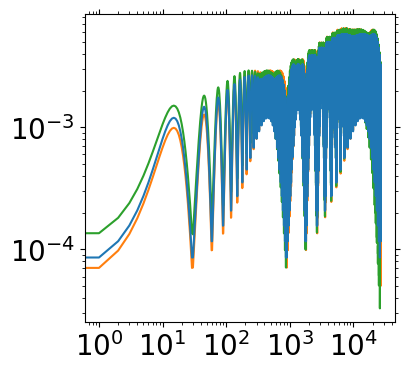

In [27]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(2):
#     utl.PltErr(range(data.descriptors[0,:].shape[0]),data.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )

# utl.PltErr(range(data.descriptors[100,:].shape[0]),data.descriptors[100,:],
#           attrs={'fmt':'-','color':'C0'},
#            xscale='log',yscale='log',
#            ax=ax,
#            Plot=False,
#           )


mkdir: png: File exists


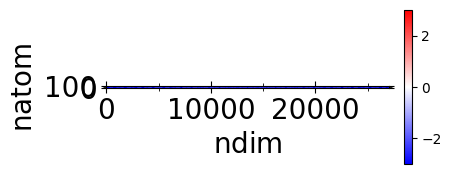

In [26]:
# data.Spectra(nrows=100)

In [3]:
help(MLPRegressor)

Help on class MLPRegressor in module sklearn.neural_network._multilayer_perceptron:

class MLPRegressor(sklearn.base.RegressorMixin, BaseMultilayerPerceptron)
 |  MLPRegressor(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |  
 |  Multi-layer Perceptron regressor.
 |  
 |  This model optimizes the squared error using LBFGS or stochastic gradient
 |  descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 'logis